# Prepare Google Colab Environment

In [3]:
!git clone https://github.com/mhamilton723/STEGO.git

Cloning into 'STEGO'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 208 (delta 51), reused 38 (delta 38), pack-reused 139
Receiving objects: 100% (208/208), 9.23 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
%pip install wget
%pip install torchmetrics
%pip install hydra-core
%pip install git+https://github.com/lucasb-eyer/pydensecrf.git
%pip install omegaconf
%pip install lightning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-8jezjt52
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-8jezjt52
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Download Pretrained Model



In [2]:
import os
from os.path import join
# os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [3]:
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [4]:
%pip install torchvision
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

Note: you may need to restart the kernel to use updated packages.


/home/valer/src/github.com/valerfisch/geo-scene/train_segmentation.py:390: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")
/home/valer/src/github.com/valerfisch/geo-scene/.conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v2.0.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


# Load Image

In [11]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from src.utils.stego_utils import get_transform

img_url ="https://lh3.googleusercontent.com/places/ANJU3Ds4WjBL-kIfANgTpY-L8l8_2-C-zTL3M6qNohdZjibmyj50hdzW0ueuplanU2jrw0_sOFjUxBs8r2_wcUeiivkdfgx2wEc4DzA=s1600-h3024"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

/home/valer/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


# Query model and pass result through CRF

In [12]:
import torch.nn.functional as F
from src.crf import dense_crf
import torch

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


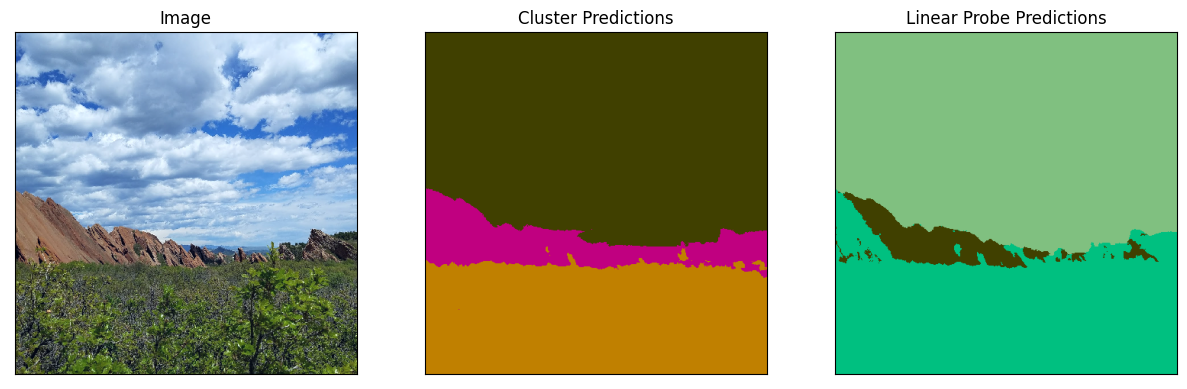

In [13]:
import matplotlib.pyplot as plt
from src.utils.stego_utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)